# PyTorch implementation of feed-forward neural networks

## Import librairies

In [1]:
from importlib import reload

import path_imports

import notebooks.save_manager
import src.classification.my_fnn_torch
import src.classification.my_naive_bayes
import src.word2vec.word2vec

reload(src.classification.my_fnn_torch)
reload(src.classification.my_naive_bayes)
reload(notebooks.save_manager)
reload(src.word2vec.word2vec)

from typing import Any, Callable, Dict, List, Tuple

import gensim.downloader
import matplotlib.pyplot as plt
import pandas as pd
from eli5.lime import TextExplainer
from gensim.models import KeyedVectors, Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from tqdm import tqdm

from notebooks.save_manager import SaveManager
from src.classification.my_fnn_torch import MyFnnTorch
from src.classification.my_logistic_regression import MyLogisticRegression
from src.classification.my_naive_bayes import (
    CountVectorizer,
    MultinomialNB,
    MyNaiveBayes,
    en_stop,
)
from src.preprocessing.utils import convertURL
from src.read_corpus import read_corpus
from src.word2vec.word2vec import create_model_word2vec

2024-05-19 09:50:24.458558: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 09:50:24.495061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 09:50:25.109198: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load and filter dataset

In [7]:
categories = ["tweet"]
presidents = ['Donald Trump', 'Barack Obama', 'Joe Biden']
df = read_corpus(categories=categories, presidents=presidents)
df

100%|██████████| 29/29 [00:03<00:00,  8.68it/s]


,category,name,date,text
0,tweet,Donald Trump,2011-08-02 18:07:48,Republicans and Democrats have both created ou...
1,tweet,Donald Trump,2020-03-03 01:34:50,I was thrilled to be back in the Great city of...
2,tweet,Donald Trump,2020-09-12 20:10:58,The Unsolicited Mail In Ballot Scam is a major...
3,tweet,Donald Trump,2020-02-01 16:14:02,Getting a little exercise this morning! https:...
4,tweet,Donald Trump,2020-10-23 04:52:14,https://t.co/4qwCKQOiOw
...,...,...,...,...
6032,tweet,Joe Biden,2020-11-01 11:40,"As president, I’ll build an economy that rewar..."
6033,tweet,Joe Biden,2020-11-01 12:01,Let’s put dogs back in the White House. https:...
6034,tweet,Joe Biden,2020-11-01 12:20,We have in our hands the ultimate power: the p...
6035,tweet,Joe Biden,2020-11-01 12:40,"We need to:\n\nBuild bridges, not walls.\nOpen..."


In [8]:
df["name"].unique()

array(['Donald Trump', 'Barack Obama', 'Joe Biden'], dtype=object)

In [9]:
timer_manager = SaveManager(categories=categories, presidents=presidents)

## Pre-process

In [10]:
convert_url = True
def preprocess(df : pd.DataFrame, convert_url : bool) -> pd.DataFrame:

    count = df.groupby(by="name").count()
    df = df[df["name"].isin(count[count["text"] > 15].index.to_list())]

    if convert_url:
        df["text"] = df["text"].apply(convertURL)
    return df

df2 = df[df["text"].str.contains("http")]
if df2.shape[0]:
    text = df2.iloc[0]["text"]
    print(text)
    print(convertURL(text))

df = preprocess(df, convert_url=convert_url)
df.shape

I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 https://t.co/dNJZfRsl9y
I was thrilled to be back in the Great city of Charlotte, North Carolina with thousands of hardworking American Patriots who love our Country, cherish our values, respect our laws, and always put AMERICA FIRST! Thank you for a wonderful evening!! #KAG2020 TOKURL


(59582, 4)

## Commun Hyperparamters

### Tokenizer

In [11]:
from src.preprocessing.regexp_tokenizer import RegexpTokenizer
from src.preprocessing.byte_pair.hugging_face import MyBpeTokenizerHuggingFace
from src.preprocessing.byte_pair.byte_pair_class import MyBpeTokenizerBytePair
from src.preprocessing.gpt_tokenizer import MyGPTTokenizer
import os

[nltk_data] Downloading package wordnet to /home/secouss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
TYPE_TOKENIZER = Callable[[str], List[str]]

#### BytePair encoding

In [13]:
# Store all the words in a file
DIR_TMP = "./tmp"
os.makedirs(DIR_TMP, exist_ok=True)
PATH_FILE_ALL_WORDS = os.path.join(DIR_TMP, "all_words.txt")
all_words = df["text"].str.cat(sep=" ")
with open(PATH_FILE_ALL_WORDS, mode="w") as writer:
    writer.write(all_words)
files_corpus = [PATH_FILE_ALL_WORDS]

In [14]:
# Create the tokenizer
with timer_manager.timer("Create MyBpeTokenizerHuggingFace"):
    bpe_tokenizer_hugging_face = MyBpeTokenizerHuggingFace.create_tokenizer(files_corpus)
print(bpe_tokenizer_hugging_face.tokenize("I don't love you"))




['ĠI', 'Ġd', 'on', "'", 't', 'Ġl', 'o', 've', 'Ġyou']


In [17]:
# ~two minutes to compute
with timer_manager.timer("Create MyBpeTokenizerBytePair"):
    bpe_tokenizer_home_made = MyBpeTokenizerBytePair.create_tokenizer(files_corpus)
bpe_tokenizer_home_made.tokenize("I don't love you")

write into file: 100%|██████████| 1031/1031 [00:00<00:00, 2160003.71it/s]


['I', ' ', 'don', ' ', "'", ' ', 't', ' ', 'lo', 've', ' ', 'y', 'ou']

#### Regexp Tokenizer

In [18]:
regexp_tokenizer = RegexpTokenizer()

#### All tokenizer

In [19]:
tokenizers = pd.DataFrame([
    ["bpe_hugging_face", bpe_tokenizer_hugging_face.tokenize],
    ["bpe_home_made", bpe_tokenizer_home_made.tokenize],
    ["lemma", regexp_tokenizer.lemma_tokenize],
    ["sent", regexp_tokenizer.sent_tokenizer],
    ["tweet", regexp_tokenizer.tweet_tokenizer],
    ["whitespaces", regexp_tokenizer.whitespaces_tokenizer],
    ["nlpReg", regexp_tokenizer.nlpReg_tokenizer],
    ["gpt", MyGPTTokenizer().tokenize]
], columns=["name", "model"])
tokenizers

,name,model
0,bpe_hugging_face,<bound method MyBpeTokenizerHuggingFace.tokeni...
1,bpe_home_made,<bound method MyBpeTokenizerBytePair.tokenize ...
2,lemma,<bound method RegexpTokenizer.lemma_tokenize o...
3,sent,<bound method RegexpTokenizer.sent_tokenizer o...
4,tweet,<bound method RegexpTokenizer.tweet_tokenizer ...
5,whitespaces,<bound method RegexpTokenizer.whitespaces_toke...
6,nlpReg,<bound method RegexpTokenizer.nlpReg_tokenizer...
7,gpt,<bound method MyGPTTokenizer.tokenize of <src....


### Word2vec

#### From dataset

In [20]:
with timer_manager.timer("create_model_word2vec"):
    word2vec_from_dataset = create_model_word2vec(df=df)
word2vec_from_dataset.vector_size

begin of Tokenisation


100%|██████████| 59582/59582 [00:08<00:00, 7155.78it/s]


1575192
End of Tokenisation
begin train
Epoch #1 end
Epoch #2 end
Epoch #3 end
Epoch #4 end
Epoch #5 end
Epoch #6 end
Epoch #7 end
Epoch #8 end
Epoch #9 end
Epoch #10 end
Time to compute : 13.466352701187134


100

In [21]:
print(word2vec_from_dataset.wv.most_similar(positive=['president', 'lincoln'],topn=1))

[('pres', 0.6165893077850342)]


#### Pre-trained

In [22]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [23]:
word2vec_pretrained50 : KeyedVectors = gensim.downloader.load('glove-wiki-gigaword-50')
word2vec_pretrained50.vector_size

50

In [24]:
word2vec_pretrained100 : KeyedVectors = gensim.downloader.load('glove-wiki-gigaword-100')
word2vec_pretrained100.vector_size

100

In [25]:
word2vec_pretrained300 : KeyedVectors = gensim.downloader.load('glove-wiki-gigaword-300')
word2vec_pretrained300.vector_size

300

#### All together

In [26]:
wvs  = pd.DataFrame([
    ["from_dataset", word2vec_from_dataset.wv],
    ["glove-wiki-gigaword-50", word2vec_pretrained50],
    ["glove-wiki-gigaword-100", word2vec_pretrained100],
    ["glove-wiki-gigaword-300", word2vec_pretrained300]
], columns=["name", "model"])
wvs

,name,model
0,from_dataset,"[[0.93498254, -0.24203962, -0.18223701, -0.261..."
1,glove-wiki-gigaword-50,"[[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -..."
2,glove-wiki-gigaword-100,"[[-0.038194, -0.24487, 0.72812, -0.39961, 0.08..."
3,glove-wiki-gigaword-300,"[[0.04656, 0.21318, -0.0074364, -0.45854, -0.0..."


### Others

In [27]:
ngram_ranges = [(1, 1), (2, 2), (3, 3)]

## Split

In [28]:
from sklearn.model_selection import StratifiedKFold

X = df["text"]
y = df["name"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, y_train.shape

((47665,), (47665,))

## Models creation and training 

### Create the models

In [29]:
import torch.nn.functional as F


class MyModel:
    def fit(**kwargs):
        pass

    def predict(**kwargs):
        pass

    def classes() -> List[str]:
        pass

    hps : dict



def init_models(
    tokenizer: TYPE_TOKENIZER,
    word2vec: Word2Vec,
    word2vec_name: str,
    ngram_range: Tuple[int, int],
    stop_words: List[str],
    hps_name: Dict[str, Any],
) -> List[MyModel]:

    stop_words = [tokenizer(word) for word in stop_words]
    init_label = "time_init"

    hps_nb = dict({**hps_name, "ngram_range": ngram_range, "balanced" : True})
    with timer_manager.timer([str(MyNaiveBayes), hps_nb, init_label]):
        naive_bayes = MyNaiveBayes(
            cv=CountVectorizer(
                ngram_range=ngram_range, tokenizer=tokenizer, stop_words=en_stop
            )
        )
        naive_bayes.hps = hps_nb
        if hps_nb["balanced"]:
            sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
            naive_bayes.fit = lambda X_train, y_train: naive_bayes.model.fit(X_train, y_train, multinomialnb__sample_weight=sample_weights)
        naive_bayes.classes = lambda: naive_bayes.clf.classes_

    hps_lr = dict(
        {
            **hps_name,
            "penalty": "l2",
            "solver": "liblinear",
            "tol": 0.0008376610960308999,
            "C": 0.2619722813789074,
            "ngram_range": ngram_range,
        }
    )
    with timer_manager.timer([str(MyLogisticRegression), hps_lr, init_label]):
        lr = MyLogisticRegression(
            cv=CountVectorizer(
                ngram_range=ngram_range, tokenizer=tokenizer, stop_words=en_stop
            ),
            clf=LogisticRegression(
                penalty=hps_lr["penalty"],
                solver=hps_lr["solver"],
                tol=hps_lr["tol"],
                C=hps_lr["C"],
                verbose=1
            ),
        )
        lr.hps = hps_lr
        lr.classes = lambda: lr.clf.classes_

    hps_fnn = dict({**hps_name, "nb_epochs": 10, "word2vec": word2vec_name})
    with timer_manager.timer([str(MyFnnTorch), hps_fnn, init_label]):
        # cv = CountVectorizer(ngram_range=(1, 1), tokenizer=tokenizer, stop_words=en_stop)
        # cv.fit(X_train)
        fnn_torch = MyFnnTorch(
            num_classes=len(y.unique()),
            nb_epochs=hps_fnn["nb_epochs"],
            word2vec=word2vec,
            tokenizer=tokenizer,
            # activation=F.relu6
            # count_vectorizer=cv,
        )
        fnn_torch.hps = hps_fnn
        fnn_torch.classes = lambda: fnn_torch.label_encoder.classes_

    models = [naive_bayes, lr, fnn_torch]
    return models


tokenizer = tokenizers.iloc[7]
wv = wvs.iloc[3]
hps_name = {
    "tokenizer": tokenizer["name"],
    "convertUrl": convert_url
}
models = init_models(
    tokenizer=tokenizer["model"],
    word2vec=wv["model"],
    word2vec_name=wv["name"],
    ngram_range=ngram_ranges[0],
    stop_words=en_stop,
    hps_name=hps_name,
)

### Train the model

In [31]:
def train(model : MyModel) -> None:
    name = str(model.__class__)
    print(name)
    with timer_manager.timer([name, model.hps, "time_train"]):
        model.fit(X_train, y_train)
def train_all(models : List[MyModel]) -> None:
    for model in tqdm(models, desc="train_models"):
        train(model)
train_all(models)

train_models:   0%|          | 0/3 [00:00<?, ?it/s]/home/secouss/repos/nlp-usa-presidents/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:394: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10138', '10274', '1055', '10655', '1073', '10888', '10924', '11536', '11945', '12116', '1220', '1225', '1245', '12682', '12840', '1336', '13397', '1348', '13486', '1395', '1409', '1431', '14336', '1445', '14622', '14724', '14965', '15031', '15145', '15205', '15247', '1527', '1531', '15930', '1605', '1610', '16514', '16809', '1683', '17106', '17206', '1729', '1752', '17998', '1820', '18238', '18614', '1885', '18864', '19041', '19171', '1919', '19553', '1962', '1964', '2000', '20019', '2002', '2017', '20322', '20375', '20583', '20670', '20708', '20969', '2099', '21470', '21704', '2177', '21903', '2201', '22479', '23478', '2351', '23609', '23770', '24567', '2465', '25030', '2530', '2544', '258', '25849', '263'

<class 'src.classification.my_naive_bayes.MyNaiveBayes'>


train_models:  33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]/home/secouss/repos/nlp-usa-presidents/.venv/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:394: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10138', '10274', '1055', '10655', '1073', '10888', '10924', '11536', '11945', '12116', '1220', '1225', '1245', '12682', '12840', '1336', '13397', '1348', '13486', '1395', '1409', '1431', '14336', '1445', '14622', '14724', '14965', '15031', '15145', '15205', '15247', '1527', '1531', '15930', '1605', '1610', '16514', '16809', '1683', '17106', '17206', '1729', '1752', '17998', '1820', '18238', '18614', '1885', '18864', '19041', '19171', '1919', '19553', '1962', '1964', '2000', '20019', '2002', '2017', '20322', '20375', '20583', '20670', '20708', '20969', '2099', '21470', '21704', '2177', '21903', '2201', '22479', '23478', '2351', '23609', '23770', '24567', '2465', '25030', '2530', '2544', '258', '25849

<class 'src.classification.my_logistic_regression.MyLogisticRegression'>
[LibLinear]iter  1 act 5.872e+03 pre 5.051e+03 delta 2.221e+00 f 8.655e+03 |g| 1.268e+04 CG   3
iter  2 act 1.518e+03 pre 1.210e+03 delta 2.737e+00 f 2.783e+03 |g| 3.445e+03 CG   4
iter  3 act 5.868e+02 pre 4.626e+02 delta 2.923e+00 f 1.265e+03 |g| 1.259e+03 CG   4
iter  4 act 2.539e+02 pre 2.008e+02 delta 3.377e+00 f 6.785e+02 |g| 4.812e+02 CG   5
cg reaches trust region boundary
iter  5 act 1.206e+02 pre 9.733e+01 delta 4.482e+00 f 4.246e+02 |g| 1.870e+02 CG   7
cg reaches trust region boundary
iter  6 act 5.160e+01 pre 4.586e+01 delta 5.187e+00 f 3.040e+02 |g| 7.807e+01 CG   8
iter  7 act 1.121e+01 pre 9.232e+00 delta 5.187e+00 f 2.524e+02 |g| 3.761e+01 CG   6
iter  8 act 3.512e+00 pre 3.039e+00 delta 5.187e+00 f 2.411e+02 |g| 1.319e+01 CG   9
iter  9 act 4.294e-01 pre 3.865e-01 delta 5.187e+00 f 2.376e+02 |g| 4.048e+00 CG   9
iter  1 act 5.204e+03 pre 4.465e+03 delta 2.742e+00 f 8.655e+03 |g| 9.009e+03 CG   4


train_models:  67%|██████▋   | 2/3 [00:05<00:02,  2.98s/it]

iter  7 act 1.406e+01 pre 1.358e+01 delta 7.407e+00 f 6.858e+02 |g| 4.392e+01 CG  13
iter  8 act 9.368e-01 pre 9.166e-01 delta 7.407e+00 f 6.718e+02 |g| 7.349e+00 CG  16
<class 'src.classification.my_fnn_torch.MyFnnTorch'>
Epoch [1/10], Loss: 0.4311
Epoch [2/10], Loss: 0.4918
Epoch [3/10], Loss: 0.3173
Epoch [4/10], Loss: 0.4523
Epoch [5/10], Loss: 0.3512
Epoch [6/10], Loss: 0.3108
Epoch [7/10], Loss: 0.4118
Epoch [8/10], Loss: 0.3973
Epoch [9/10], Loss: 0.4782


train_models: 100%|██████████| 3/3 [00:26<00:00,  8.99s/it]

Epoch [10/10], Loss: 0.4055


### Prediction

In [32]:
text = df[df["name"] == "Donald Trump"].iloc[0]["text"]
print(text)
def predict(models :List[MyModel], text : str) -> None:
    for model in tqdm(models, desc="train_models"):
        print(model, model.predict([text]))
predict(models, text)

Republicans and Democrats have both created our economic problems.


train_models: 100%|██████████| 3/3 [00:00<00:00, 839.92it/s]

<src.classification.my_naive_bayes.MyNaiveBayes object at 0x7e7774712ec0> ['Donald Trump']
<src.classification.my_logistic_regression.MyLogisticRegression object at 0x7e7774711540> ['Donald Trump']
<src.classification.my_fnn_torch.MyFnnTorch object at 0x7e7774712b90> ['Joe Biden']


## Evaluation

### Table (precision, recall, f1-score)

In [142]:
models[2].fit(X_train, y_train, X_test, y_test)

Epoch [1/200], Loss: 2.1362
Precision: 0.1254, Recall: 0.2258, F1 Score: 0.1382
Epoch [2/200], Loss: 1.9465
Precision: 0.1166, Recall: 0.2284, F1 Score: 0.1454
Epoch [3/200], Loss: 2.3751
Precision: 0.1402, Recall: 0.2309, F1 Score: 0.1489
Epoch [4/200], Loss: 1.9042
Precision: 0.1121, Recall: 0.1970, F1 Score: 0.1283
Epoch [5/200], Loss: 2.0631
Precision: 0.1274, Recall: 0.2384, F1 Score: 0.1604
Epoch [6/200], Loss: 2.2421
Precision: 0.1156, Recall: 0.2058, F1 Score: 0.1232
Epoch [7/200], Loss: 2.1447
Precision: 0.1310, Recall: 0.2284, F1 Score: 0.1514
Epoch [8/200], Loss: 1.9935
Precision: 0.1127, Recall: 0.1844, F1 Score: 0.1195
Epoch [9/200], Loss: 2.0367
Precision: 0.1409, Recall: 0.2196, F1 Score: 0.1599
Epoch [10/200], Loss: 2.0395
Precision: 0.1479, Recall: 0.2371, F1 Score: 0.1747
Epoch [11/200], Loss: 2.1700
Precision: 0.1613, Recall: 0.2221, F1 Score: 0.1584
Epoch [12/200], Loss: 2.1098
Precision: 0.1465, Recall: 0.2371, F1 Score: 0.1558
Epoch [13/200], Loss: 2.1069
Precisio

KeyboardInterrupt: 

In [33]:
def evaluation(model : List[MyModel]):
    print(model.__class__)
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    d = classification_report(y_test, y_pred, output_dict=True)
    timer_manager.fill([str(model.__class__), model.hps, "classification_report"], d)

def evaluation_all(models : List[MyModel]):
    for model in models:
        evaluation(model)

evaluation_all(models)

<class 'src.classification.my_naive_bayes.MyNaiveBayes'>
Classification Report:
               precision    recall  f1-score   support

Barack Obama       0.77      0.95      0.85      1362
Donald Trump       0.99      0.91      0.95      9345
   Joe Biden       0.69      0.92      0.79      1210

    accuracy                           0.92     11917
   macro avg       0.82      0.93      0.86     11917
weighted avg       0.94      0.92      0.92     11917

<class 'src.classification.my_logistic_regression.MyLogisticRegression'>
Classification Report:
               precision    recall  f1-score   support

Barack Obama       0.99      0.96      0.98      1362
Donald Trump       0.98      1.00      0.99      9345
   Joe Biden       0.95      0.87      0.91      1210

    accuracy                           0.98     11917
   macro avg       0.97      0.94      0.96     11917
weighted avg       0.98      0.98      0.98     11917

<class 'src.classification.my_fnn_torch.MyFnnTorch'>
Classif

### Confusion Matrix

<class 'src.classification.my_naive_bayes.MyNaiveBayes'>


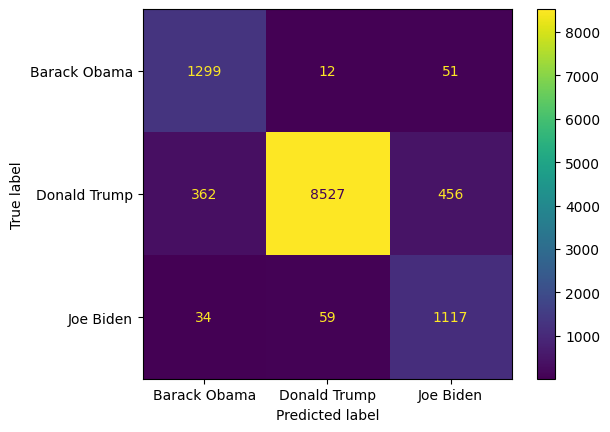

<class 'src.classification.my_logistic_regression.MyLogisticRegression'>


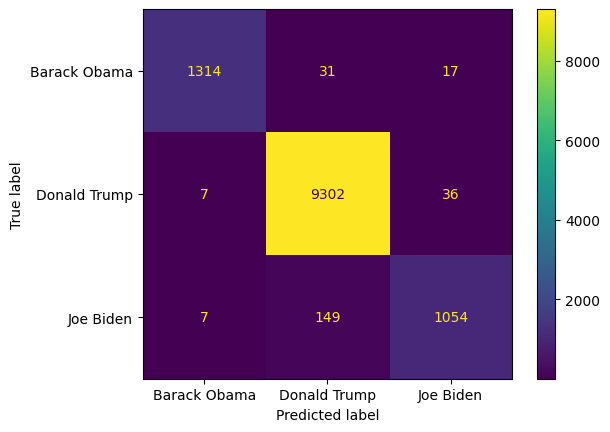

<class 'src.classification.my_fnn_torch.MyFnnTorch'>


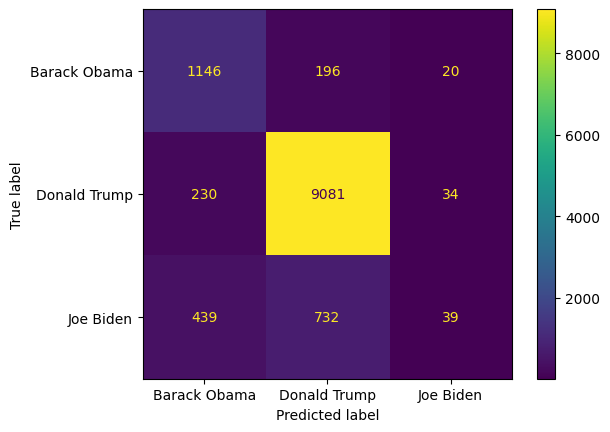

In [34]:
DIR = "./tmp/cm"
os.makedirs(DIR, exist_ok=True)
def evaluation_cm(model : MyModel):
    print(model.__class__)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes())
    disp.plot()
    namefile = str(model.__class__) + "_".join(f"[{name}:{e}]" for name, e in model.hps.items()) +".png"
    plt.savefig(os.path.join(DIR, namefile))
    plt.show()

def evaluation_cm_all(models : List[MyModel]):
    for model in models:
        evaluation_cm(model)
 
evaluation_cm_all(models)

## Explicability

In [37]:
model = models[0]
df["pred"] = model.predict(X)

In [38]:
dfp2 = df.copy()
b = True
if b:
    true_label = "Donald Trump"
    pred_label = "Joe Biden"
    dfp2 = dfp2[dfp2["name"] == true_label]
    dfp2 = dfp2[dfp2["pred"] == pred_label]

if not b:
    dfp2 = dfp2[dfp2["text"].str.contains("week")]
    print(dfp2.groupby(by="name").count())

sample = dfp2.iloc[7]
text = sample["text"]
name = sample["name"]
text, name

('WE ARE MAKING BIG PROGRESS. RESULTS START TO COME IN NEXT WEEK. MAKE AMERICA GREAT AGAIN!',
 'Donald Trump')

In [39]:
predict_proba = model.model.predict_proba
predict_proba([text])

array([[3.21919677e-04, 1.41534206e-01, 8.58143874e-01]])

In [40]:
te = TextExplainer(random_state=42, n_samples=5000)
te.fit(text, lambda X : predict_proba(X))
te.show_prediction(target_names=list(model.classes()))

/home/secouss/repos/nlp-usa-presidents/.venv/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/secouss/repos/nlp-usa-presidents/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
